# Group 14 - Phase 3
* Andrei Oprea (1768905)
* Syeni Edith Perea Zelaya (2064936)
* Yujie Zhang (1817787)



## Imports & Data Loading

In [1]:
import pandas as pd
import pm4py
from urllib.request import urlretrieve
import os
import numpy as np
import sklearn
import torch
import torch.nn as nn
from tqdm.auto import tqdm

In [27]:
import os
# os.path.abspath(os.getcwd()+'/.../')
os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
data_raw = pm4py.read_xes(os.path.abspath(os.path.join(os.getcwd(), '..', 'data')) + '\BPI_Challenge_2017.xes.gz')


parsing log, completed traces :: 100%|██████████| 31509/31509 [00:39<00:00, 793.16it/s]


In [29]:
len(data_raw)

31509

In [31]:
# number of distinct trace variants
len(pm4py.get_variants_as_tuples(data_raw))

15930

In [32]:
# how does the process start
pm4py.get_start_activities(data_raw)

{'A_Create Application': 31509}

In [33]:
# how does the process end
pm4py.get_end_activities(data_raw)

{'W_Validate application': 12662,
 'O_Cancelled': 4436,
 'W_Call after offers': 9457,
 'W_Call incomplete files': 4676,
 'W_Complete application': 144,
 'W_Assess potential fraud': 102,
 'W_Personal Loan collection': 2,
 'W_Shortened completion ': 5,
 'A_Denied': 1,
 'O_Sent (online only)': 8,
 'O_Sent (mail and online)': 15,
 'O_Returned': 1}

In [34]:
from pm4py.objects.log.util.log import project_traces
def print_nth(log, index):
    print(str(project_traces(data_raw)[index]))

In [35]:
print_nth(data_raw, 0)

['A_Create Application', 'A_Submitted', 'W_Handle leads', 'W_Handle leads', 'W_Complete application', 'A_Concept', 'W_Complete application', 'W_Complete application', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Complete application', 'W_Call after offers', 'W_Call after offers', 'A_Complete', 'W_Call after offers', 'W_Call after offers', 'W_Call after offers', 'W_Call after offers', 'W_Validate application', 'W_Validate application', 'A_Validating', 'O_Returned', 'W_Validate application', 'W_Validate application', 'W_Call incomplete files', 'W_Call incomplete files', 'A_Incomplete', 'W_Call incomplete files', 'W_Call incomplete files', 'W_Call incomplete files', 'W_Call incomplete files', 'W_Validate application', 'W_Validate application', 'A_Validating', 'W_Validate application', 'O_Accepted', 'A_Pending', 'W_Validate application']


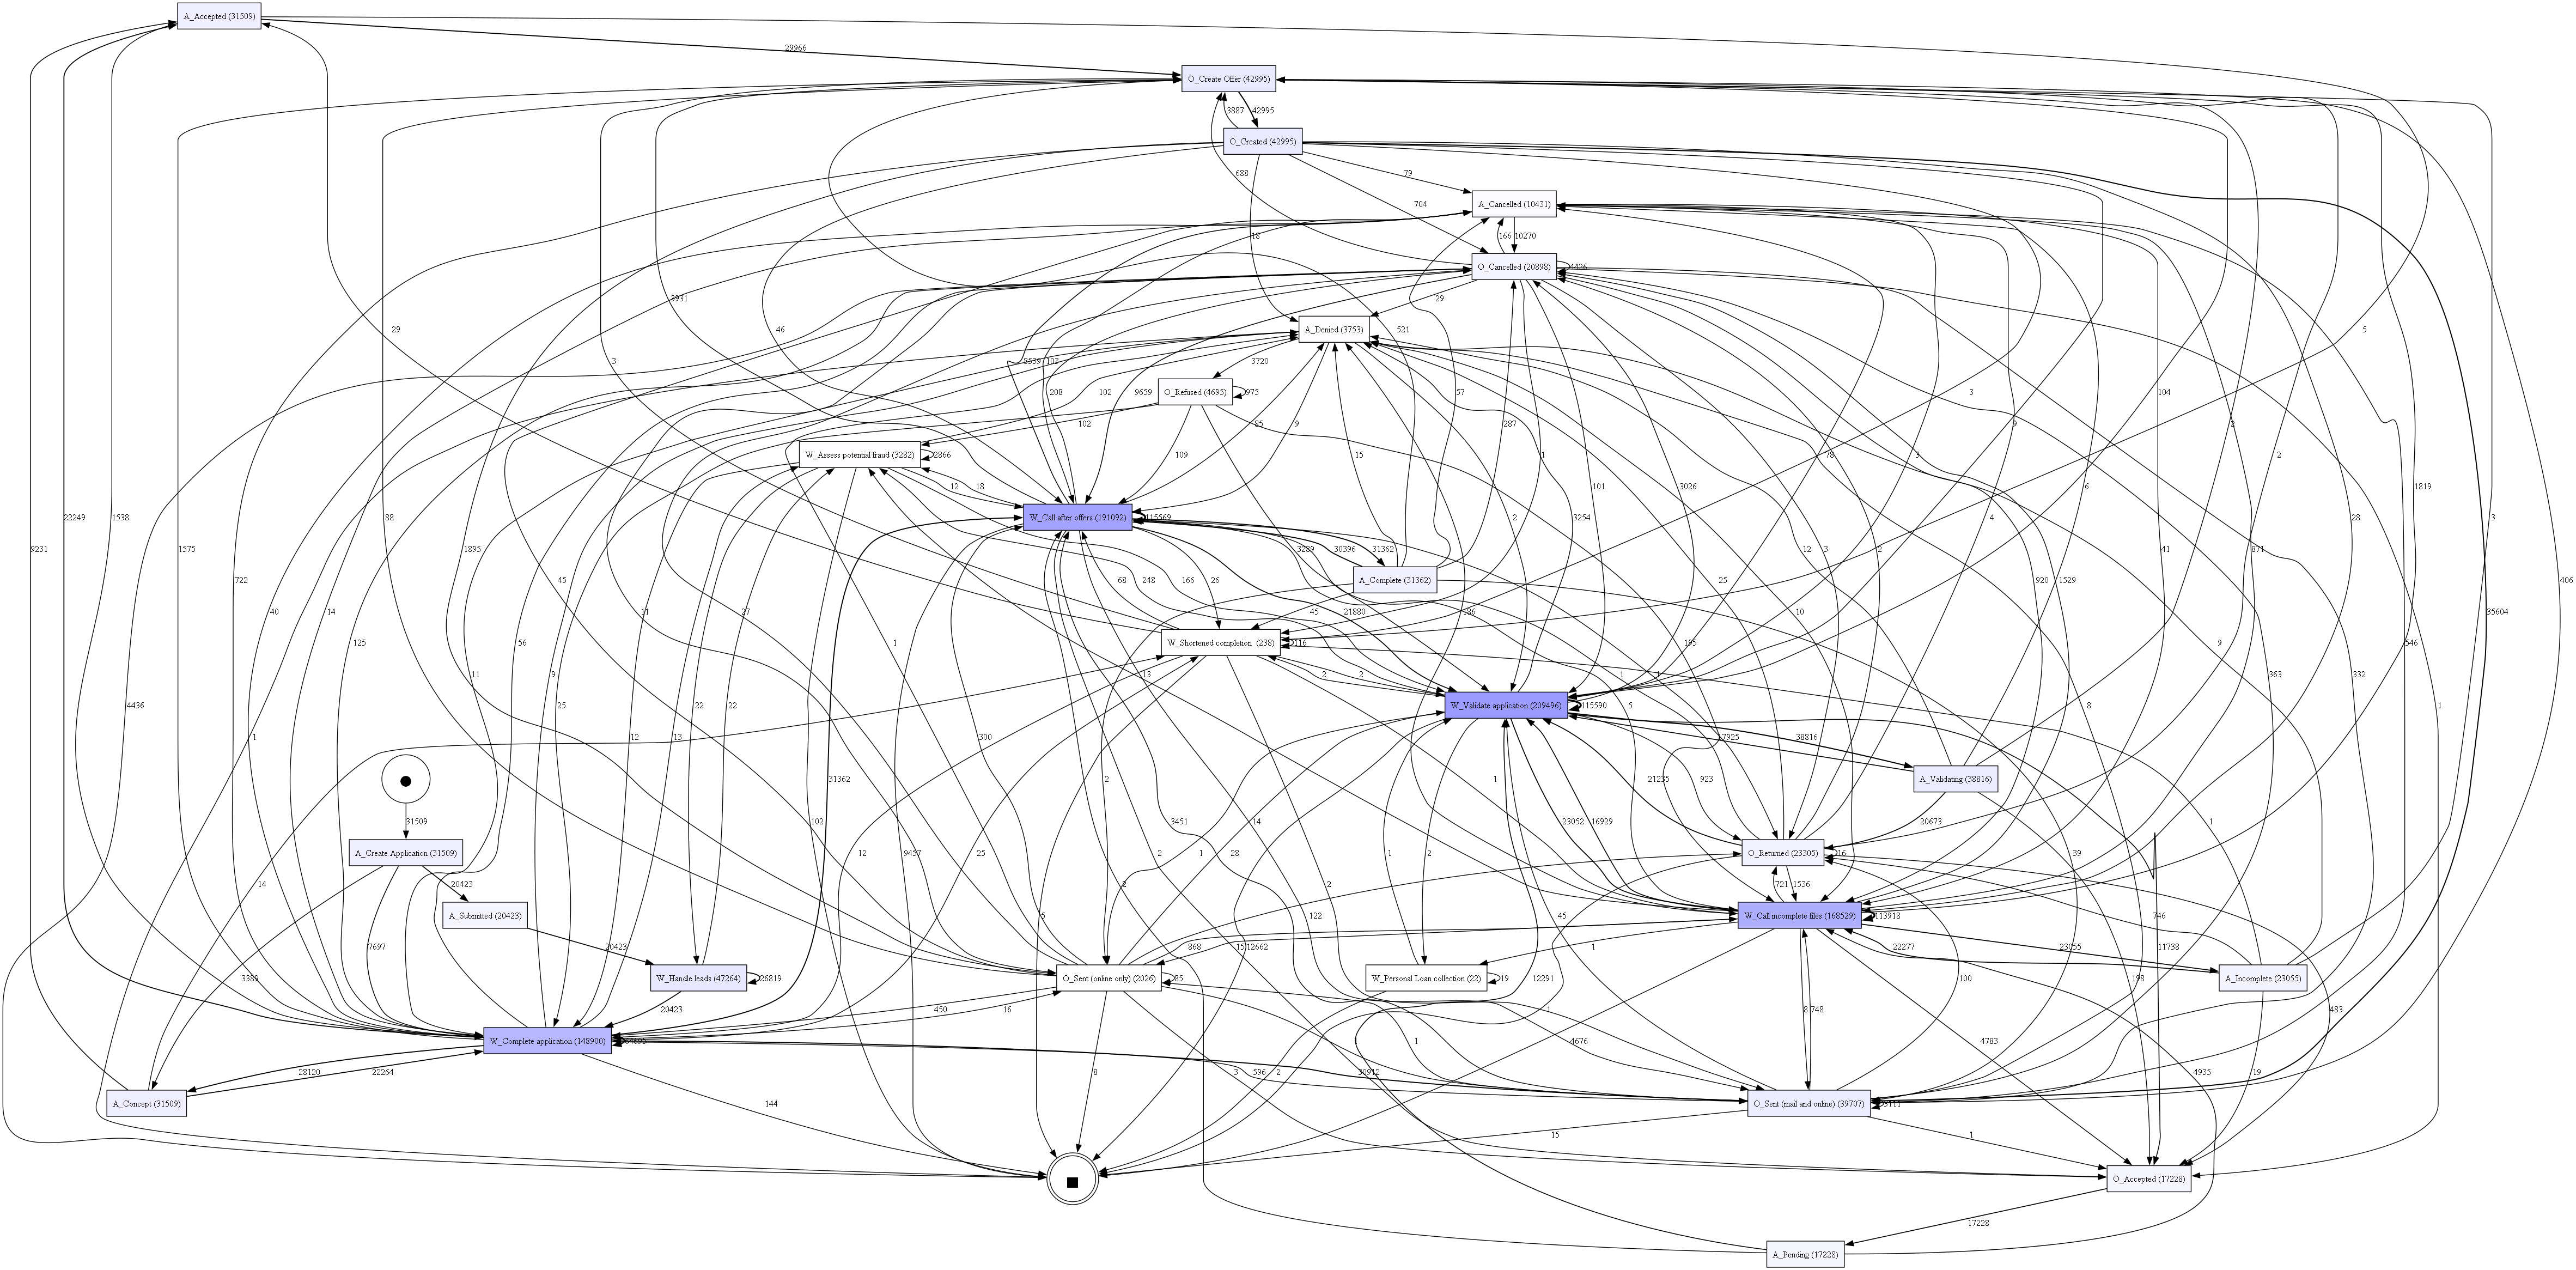

In [36]:
dfg, start_activities, end_activities = pm4py.discover_dfg(data_raw)
pm4py.view_dfg(dfg, start_activities, end_activities)

In [37]:
data_filtered = pm4py.filter_event_attribute_values(data_raw, 
                                    attribute_key = 'concept:name', # special column for the activity name always added by PM4Py
                                    values = ['W_PersonalLoan collection', 'W_Handle leads', 'A_Validating'], 
                                    level = 'event',    # we want to keep all traces and modify events
                                    retain = False)     # remove matching events

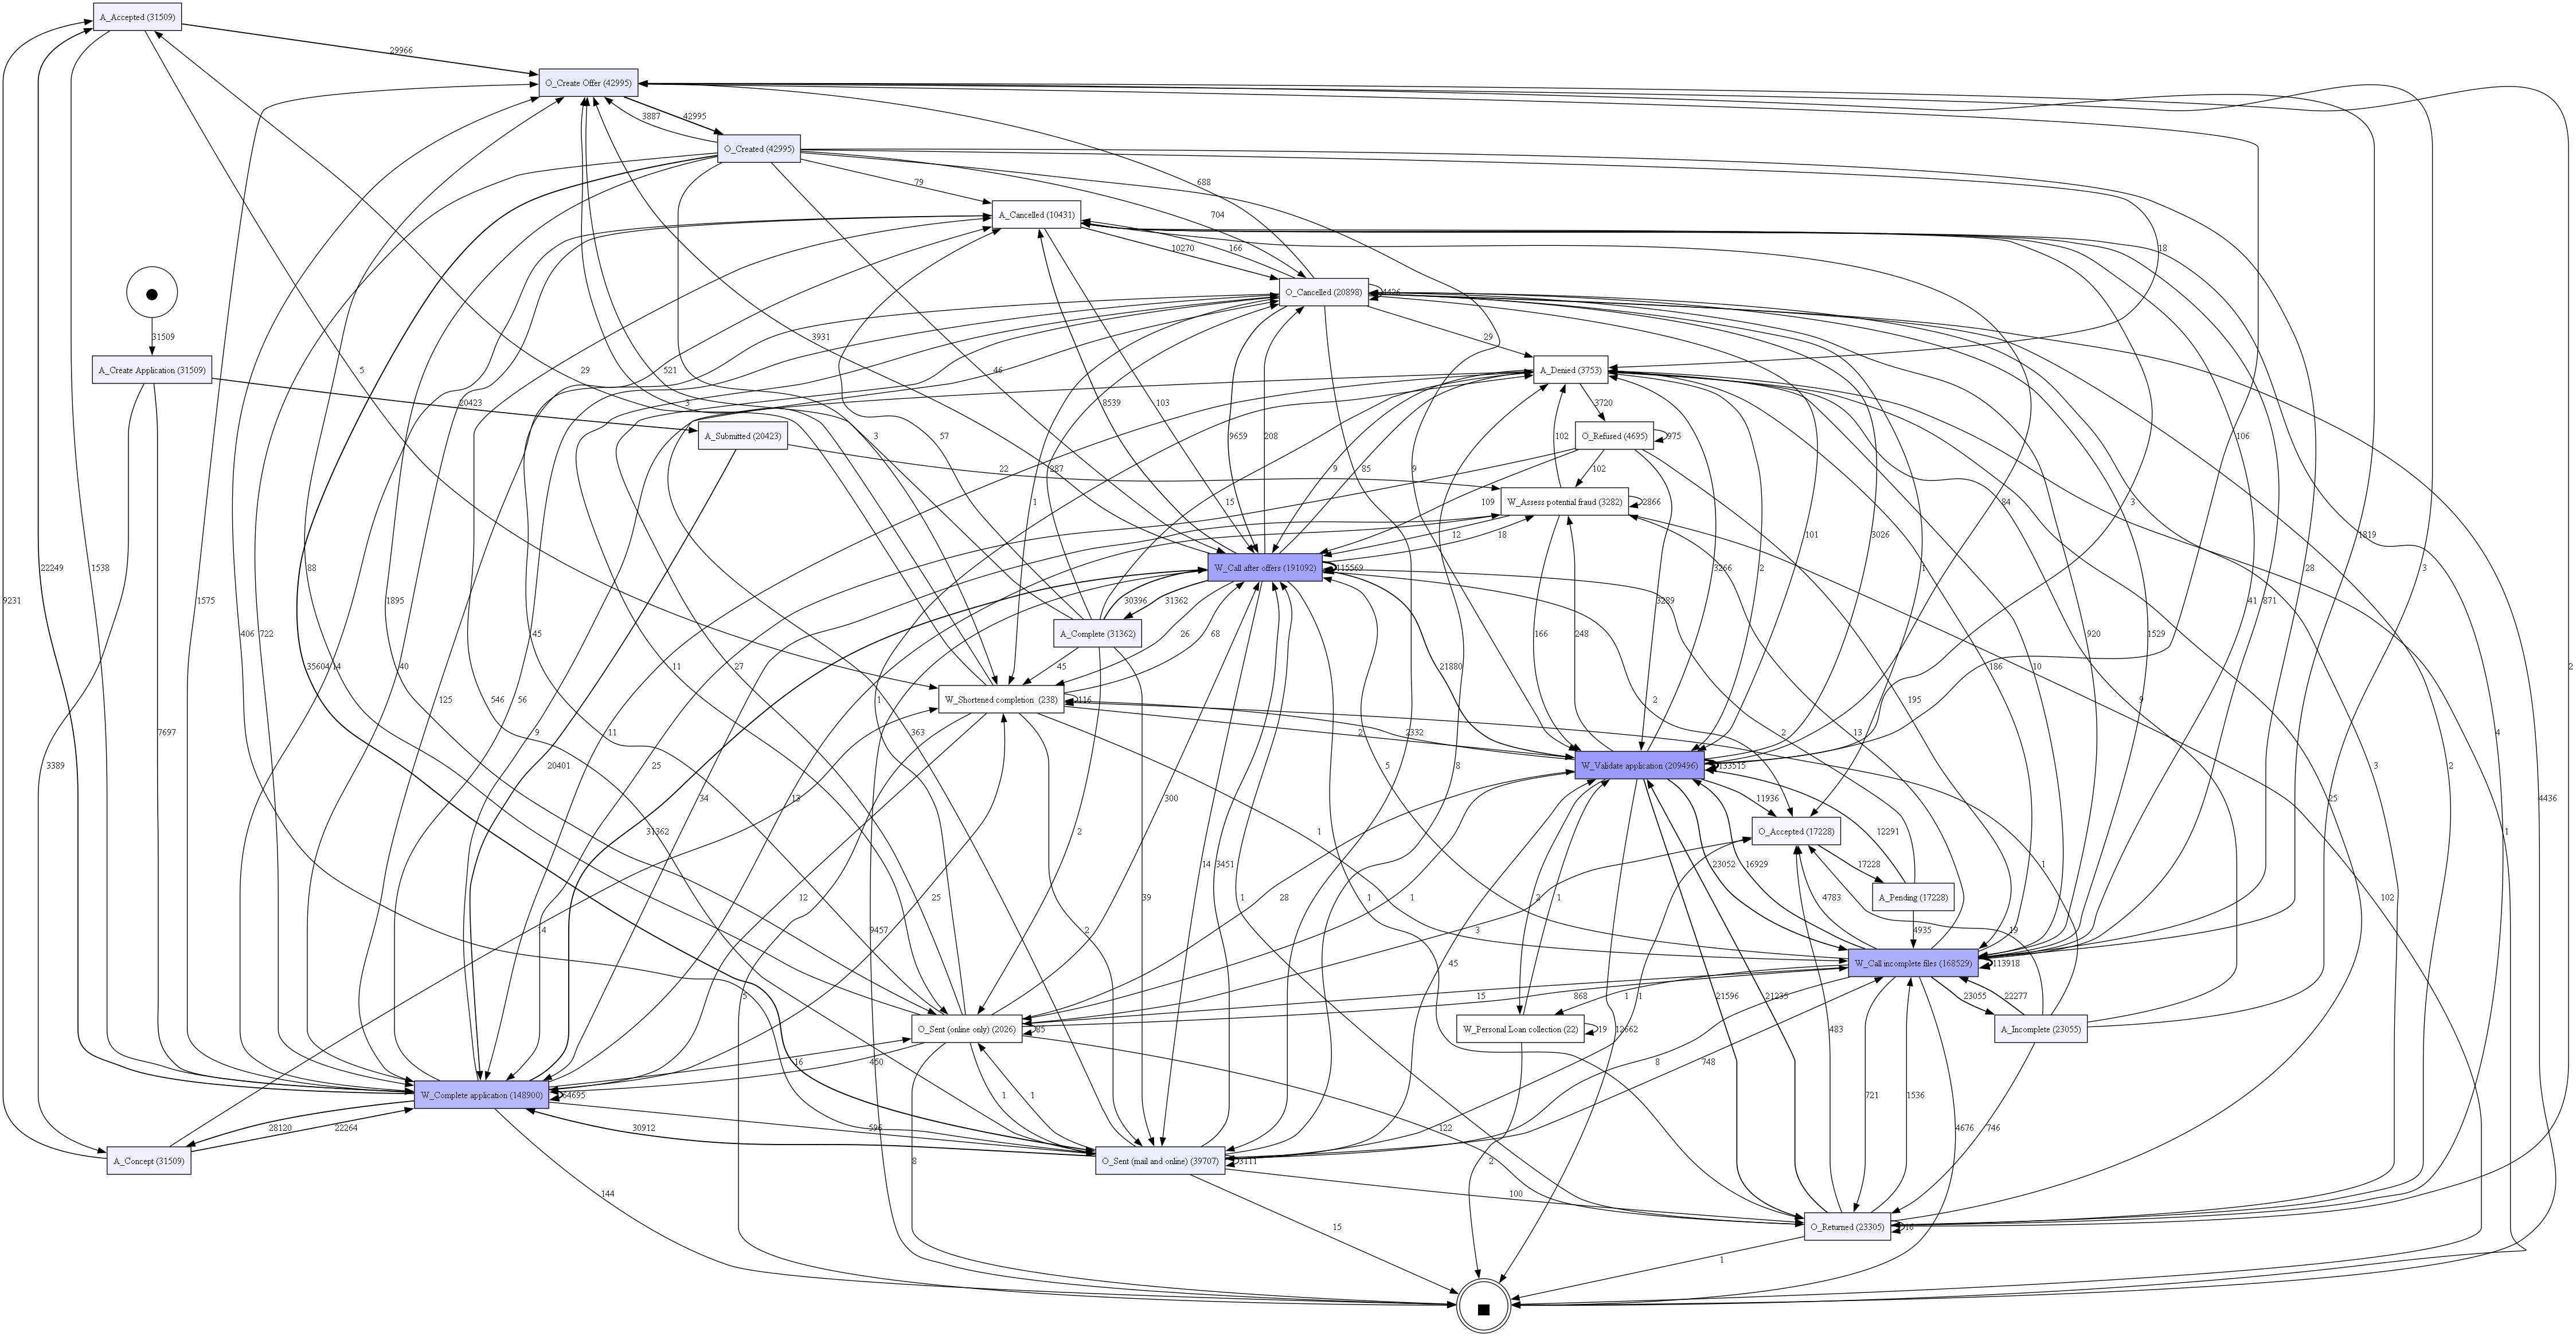

In [38]:
dfg, start_activities, end_activities = pm4py.discover_dfg(data_filtered)
pm4py.view_dfg(dfg, start_activities, end_activities)

In [39]:
pm4py.get_event_attributes(data_raw)

['EventOrigin',
 'time:timestamp',
 'case:RequestedAmount',
 'case:concept:name',
 'FirstWithdrawalAmount',
 'CreditScore',
 'MonthlyCost',
 'OfferID',
 'NumberOfTerms',
 'case:ApplicationType',
 'Action',
 'Selected',
 'case:LoanGoal',
 'concept:name',
 'EventID',
 'OfferedAmount',
 'org:resource',
 'Accepted']

In [40]:
pm4py.get_event_attribute_values(data_raw, 'CreditScore')

{979: 89,
 0: 27735,
 1059: 17,
 834: 39,
 799: 43,
 835: 65,
 1021: 18,
 770: 21,
 1004: 90,
 875: 54,
 919: 70,
 1063: 23,
 809: 39,
 990: 32,
 1018: 26,
 812: 61,
 895: 73,
 1030: 97,
 859: 74,
 933: 44,
 662: 7,
 860: 71,
 938: 84,
 796: 74,
 1011: 65,
 976: 33,
 659: 6,
 804: 27,
 808: 31,
 1090: 28,
 894: 54,
 955: 45,
 972: 47,
 1108: 11,
 873: 53,
 956: 84,
 1016: 55,
 1078: 9,
 853: 59,
 1034: 36,
 831: 48,
 787: 40,
 793: 34,
 756: 14,
 682: 1,
 908: 60,
 886: 46,
 827: 30,
 889: 60,
 943: 102,
 806: 59,
 953: 52,
 871: 43,
 904: 103,
 837: 30,
 844: 70,
 951: 77,
 1023: 27,
 869: 59,
 1064: 73,
 811: 25,
 887: 62,
 1033: 33,
 1010: 37,
 1006: 35,
 994: 52,
 1067: 26,
 920: 54,
 980: 33,
 884: 44,
 862: 61,
 868: 67,
 794: 30,
 838: 43,
 743: 32,
 962: 60,
 918: 51,
 983: 66,
 851: 64,
 1047: 9,
 986: 78,
 926: 72,
 1009: 28,
 952: 72,
 1039: 53,
 667: 5,
 1124: 23,
 710: 12,
 722: 13,
 1076: 23,
 746: 21,
 846: 55,
 758: 18,
 947: 56,
 1013: 55,
 957: 43,
 598: 3,
 870: 60,


## Data Preparation

In [55]:
# data_lables = [len(list(filter(lambda e: e['concept:name'] == 'A_Accepted', trace))) > 0 for trace in data_raw]

In [57]:
# convert log to dataframe
df = pm4py.convert_to_dataframe(data_raw)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202267 entries, 0 to 1202266
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   Action                 1202267 non-null  object             
 1   org:resource           1202267 non-null  object             
 2   concept:name           1202267 non-null  object             
 3   EventOrigin            1202267 non-null  object             
 4   EventID                1202267 non-null  object             
 5   lifecycle:transition   1202267 non-null  object             
 6   time:timestamp         1202267 non-null  datetime64[ns, UTC]
 7   case:LoanGoal          1202267 non-null  object             
 8   case:ApplicationType   1202267 non-null  object             
 9   case:concept:name      1202267 non-null  object             
 10  case:RequestedAmount   1202267 non-null  float64            
 11  FirstWithdrawalAmount  4

In [ ]:
#Keep only relevant features
df_feat = df['Action', 'org:resource', 'concept:name', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time:timestamp', 'case:LoanGoal',
       'case:ApplicationType', 'case:concept:name', 'case:RequestedAmount',
       'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost',
       'Selected', 'CreditScore', 'OfferedAmount', 'OfferID'].copy()

In [58]:
df.head()

Action org:resource            concept:name  EventOrigin  \
0      Created       User_1    A_Create Application  Application   
1  statechange       User_1             A_Submitted  Application   
2      Created       User_1          W_Handle leads     Workflow   
3      Deleted       User_1          W_Handle leads     Workflow   
4      Created       User_1  W_Complete application     Workflow   

                 EventID lifecycle:transition  \
0  Application_652823628             complete   
1   ApplState_1582051990             complete   
2    Workitem_1298499574             schedule   
3    Workitem_1673366067             withdraw   
4    Workitem_1493664571             schedule   

                    time:timestamp           case:LoanGoal  \
0 2016-01-01 09:51:15.304000+00:00  Existing loan takeover   
1 2016-01-01 09:51:15.352000+00:00  Existing loan takeover   
2 2016-01-01 09:51:15.774000+00:00  Existing loan takeover   
3 2016-01-01 09:52:36.392000+00:00  Existing loan takeover   
4 2016-01-01 09:52:36.403000+00:00  Existing loan takeover   

  case:ApplicationType      case:concept:name  case:RequestedAmount  \
0           New credit  Application_652823628               20000.0   
1           New credit  Application_652823628               20000.0   
2           New credit  Application_652823628               20000.0   
3           New credit  Application_652823628               20000.0   
4           New credit  Application_652823628               20000.0   

   FirstWithdrawalAmount  NumberOfTerms Accepted  MonthlyCost Selected  \
0                    NaN            NaN      NaN          NaN      NaN   
1                    NaN            NaN      NaN          NaN      NaN   
2                    NaN            NaN      NaN          NaN      NaN   
3                    NaN            NaN      NaN          NaN      NaN   
4                    NaN            NaN      NaN          NaN      NaN   

   CreditScore  OfferedAmount OfferID  
0          NaN            NaN     NaN  
1          NaN            NaN     NaN  
2          NaN            NaN     NaN  
3          NaN            NaN     NaN  
4          NaN            NaN     NaN

## Prediction